## 1. Credit card applications
<p>Commercial banks receive <em>a lot</em> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.</p>
<p><img src="https://assets.datacamp.com/production/project_558/img/credit_card.jpg" alt="Credit card being held in hand"></p>
<p>We'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. The structure of this notebook is as follows:</p>
<ul>
<li>First, we will start off by loading and viewing the dataset.</li>
<li>We will see that the dataset has a mixture of both numerical and non-numerical features, that it contains values from different ranges, plus that it contains a number of missing entries.</li>
<li>We will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.</li>
<li>After our data is in good shape, we will do some exploratory data analysis to build our intuitions.</li>
<li>Finally, we will build a machine learning model that can predict if an individual's application for a credit card will be accepted.</li>
</ul>
<p>First, loading and viewing the dataset. We find that since this data is confidential, the contributor of the dataset has anonymized the feature names.</p>

In [70]:
display(HTML("<style>.container { width:100% !important; }</style>"))
css = open('../style-table.css').read() + open('../style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [71]:
# Import pandas
import pandas as pd

import warnings; 
warnings.simplefilter('ignore')

# Load dataset
cc_apps = pd.read_csv("datasets/cc_approvals.csv",header=None, na_values = '?')

# Inspect data
cc_apps.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [72]:
cc_apps.columns = ['Gender',
                  'Age',
                  'Debt',
                  'Married',
                  'BankCustomer',
                  'EducationLevel',
                  'Ethnicity',
                  'YearsEmployed',
                  'PriorDefault',
                  'Employed',
                  'CreditScore',
                  'DriversLicense',
                  'Citizen',
                  'Zipcode',
                  'Income',
                  'ApprovalStatus']

# How many rows in total, and how many rows with NA values?

In [73]:
print(cc_apps.shape[0])

690


In [74]:
cc_apps.isnull().sum(axis = 1).astype(bool).sum()

37

In [75]:
cc_apps.dropna(axis = 0, inplace = True)

cc_apps.Age = cc_apps.Age.astype(float)

cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          653 non-null    object 
 1   Age             653 non-null    float64
 2   Debt            653 non-null    float64
 3   Married         653 non-null    object 
 4   BankCustomer    653 non-null    object 
 5   EducationLevel  653 non-null    object 
 6   Ethnicity       653 non-null    object 
 7   YearsEmployed   653 non-null    float64
 8   PriorDefault    653 non-null    object 
 9   Employed        653 non-null    object 
 10  CreditScore     653 non-null    int64  
 11  DriversLicense  653 non-null    object 
 12  Citizen         653 non-null    object 
 13  Zipcode         653 non-null    float64
 14  Income          653 non-null    int64  
 15  ApprovalStatus  653 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.7+ KB


# Inspect object columns

In [76]:
import sys, os
sys.path.append(os.path.abspath("../"))
from util.util import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
obj_count = value_counts_for_object_columns(cc_apps)
obj_count.tail(10)

value_count
col_name       col_value             
PriorDefault   t                349.0
Employed       f                366.0
               t                287.0
DriversLicense f                351.0
               t                302.0
Citizen        g                598.0
               p                  2.0
               s                 53.0
ApprovalStatus +                296.0
               -                357.0

# Convert target variable to 1/0 from +/-

In [78]:
cc_apps['ApprovalStatus'] = cc_apps['ApprovalStatus'].replace({'+' : 1, '-' : 0})
cc_apps

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Zipcode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260.0,0,0
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200.0,394,0
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200.0,1,0
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280.0,750,0


# LabelEncoder to encode categorical values

In [79]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in cc_apps.select_dtypes(include = ['object']):
    le.fit(cc_apps[col])
    cc_apps[col]=le.transform(cc_apps[col])

cc_apps.head(5)

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Zipcode,Income,ApprovalStatus
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,202.0,0,1
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,43.0,560,1
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,280.0,824,1
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,100.0,3,1
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,120.0,0,1


# Test train split

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
cc_apps_values = cc_apps.values
X = cc_apps_values[:, :-1]
y = cc_apps_values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state = 123,
                                                    stratify = y)

# Run gradientboost with default parameters

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [83]:
gb_clf = GradientBoostingClassifier()

In [84]:
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

F1 Score: 0.9932
Accuracy: 0.9939


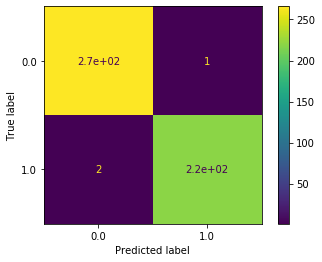

In [94]:
eval_clf(gb_clf, X_train, y_train)

F1 Score: 0.8138
Accuracy: 0.8354


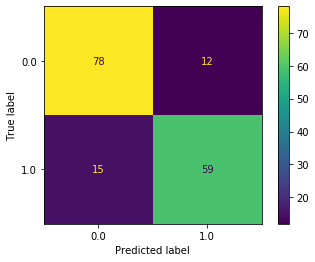

In [85]:
eval_clf(gb_clf, X_test, y_test)

# Accuracy and F1 score for training dataset are both > 0.99, and for test dataset it is 0.81 and 0.83, indicating overfitting

# For default clf, n_estimators=100, and max_depth = 3, is this the best params?

# Try use grid search

In [95]:
# Define the grid of values for tol and max_iter
n_estimators = [10, 30, 50]
max_depth = [1, 2, 3, 4]
# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [96]:
# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=gb_clf, 
                          param_grid=param_grid, 
                          cv=5,
                         )

# Fit data to grid_model
grid_model_result = grid_model.fit(X_train, y_train)

In [97]:
# Summarize results
best_score = grid_model_result.best_score_

best_params = grid_model_result.best_params_

best_clf = grid_model_result.best_estimator_

print(f"Best score: {best_score:.4f}, Best para: {best_params}")

Best score: 0.8814, Best para: {'max_depth': 2, 'n_estimators': 30}


# Grid search says max_depth = 2 and n_estimators = 30 is better

F1 Score: 0.8841
Accuracy: 0.8896


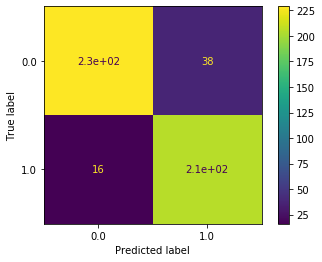

In [99]:
eval_clf(best_clf, X_train, y_train)

F1 Score: 0.8553
Accuracy: 0.8598


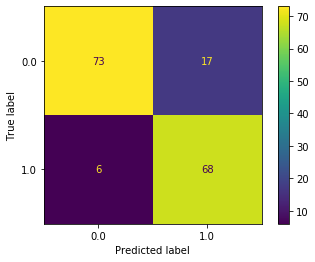

In [98]:
eval_clf(best_clf, X_test, y_test)

# Accuracy and F1 score for training dataset are both ~ 0.88, and for test dataset they are ~ 0.85. Overfitting reduced

In [126]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree


In [127]:
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [129]:
model.get_booster().feature_names = cc_apps.columns.tolist()[:-1]
model.get_booster().feature_names

['Gender',
 'Age',
 'Debt',
 'Married',
 'BankCustomer',
 'EducationLevel',
 'Ethnicity',
 'YearsEmployed',
 'PriorDefault',
 'Employed',
 'CreditScore',
 'DriversLicense',
 'Citizen',
 'Zipcode',
 'Income']

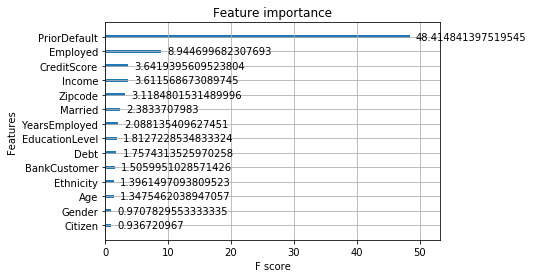

In [130]:
plot_importance(model, importance_type = 'gain')

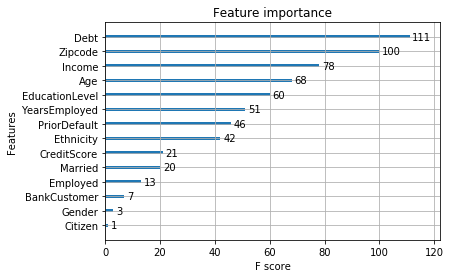

In [131]:
plot_importance(model)

In [102]:
print(model.feature_importances_)

[0.01184888 0.01644745 0.0214503  0.0290902  0.0183814  0.02212516
 0.01704068 0.02548671 0.5909266  0.10917439 0.04445164 0.
 0.01143313 0.03806256 0.04408095]


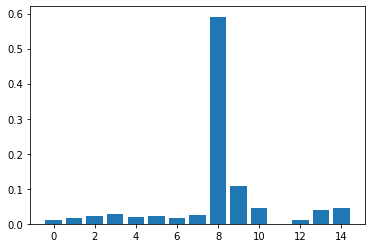

In [108]:
plt.bar(list(range(15)), model.feature_importances_)
plt.show()

In [111]:
cc_apps.columns.tolist()[:-1]

['Gender',
 'Age',
 'Debt',
 'Married',
 'BankCustomer',
 'EducationLevel',
 'Ethnicity',
 'YearsEmployed',
 'PriorDefault',
 'Employed',
 'CreditScore',
 'DriversLicense',
 'Citizen',
 'Zipcode',
 'Income']

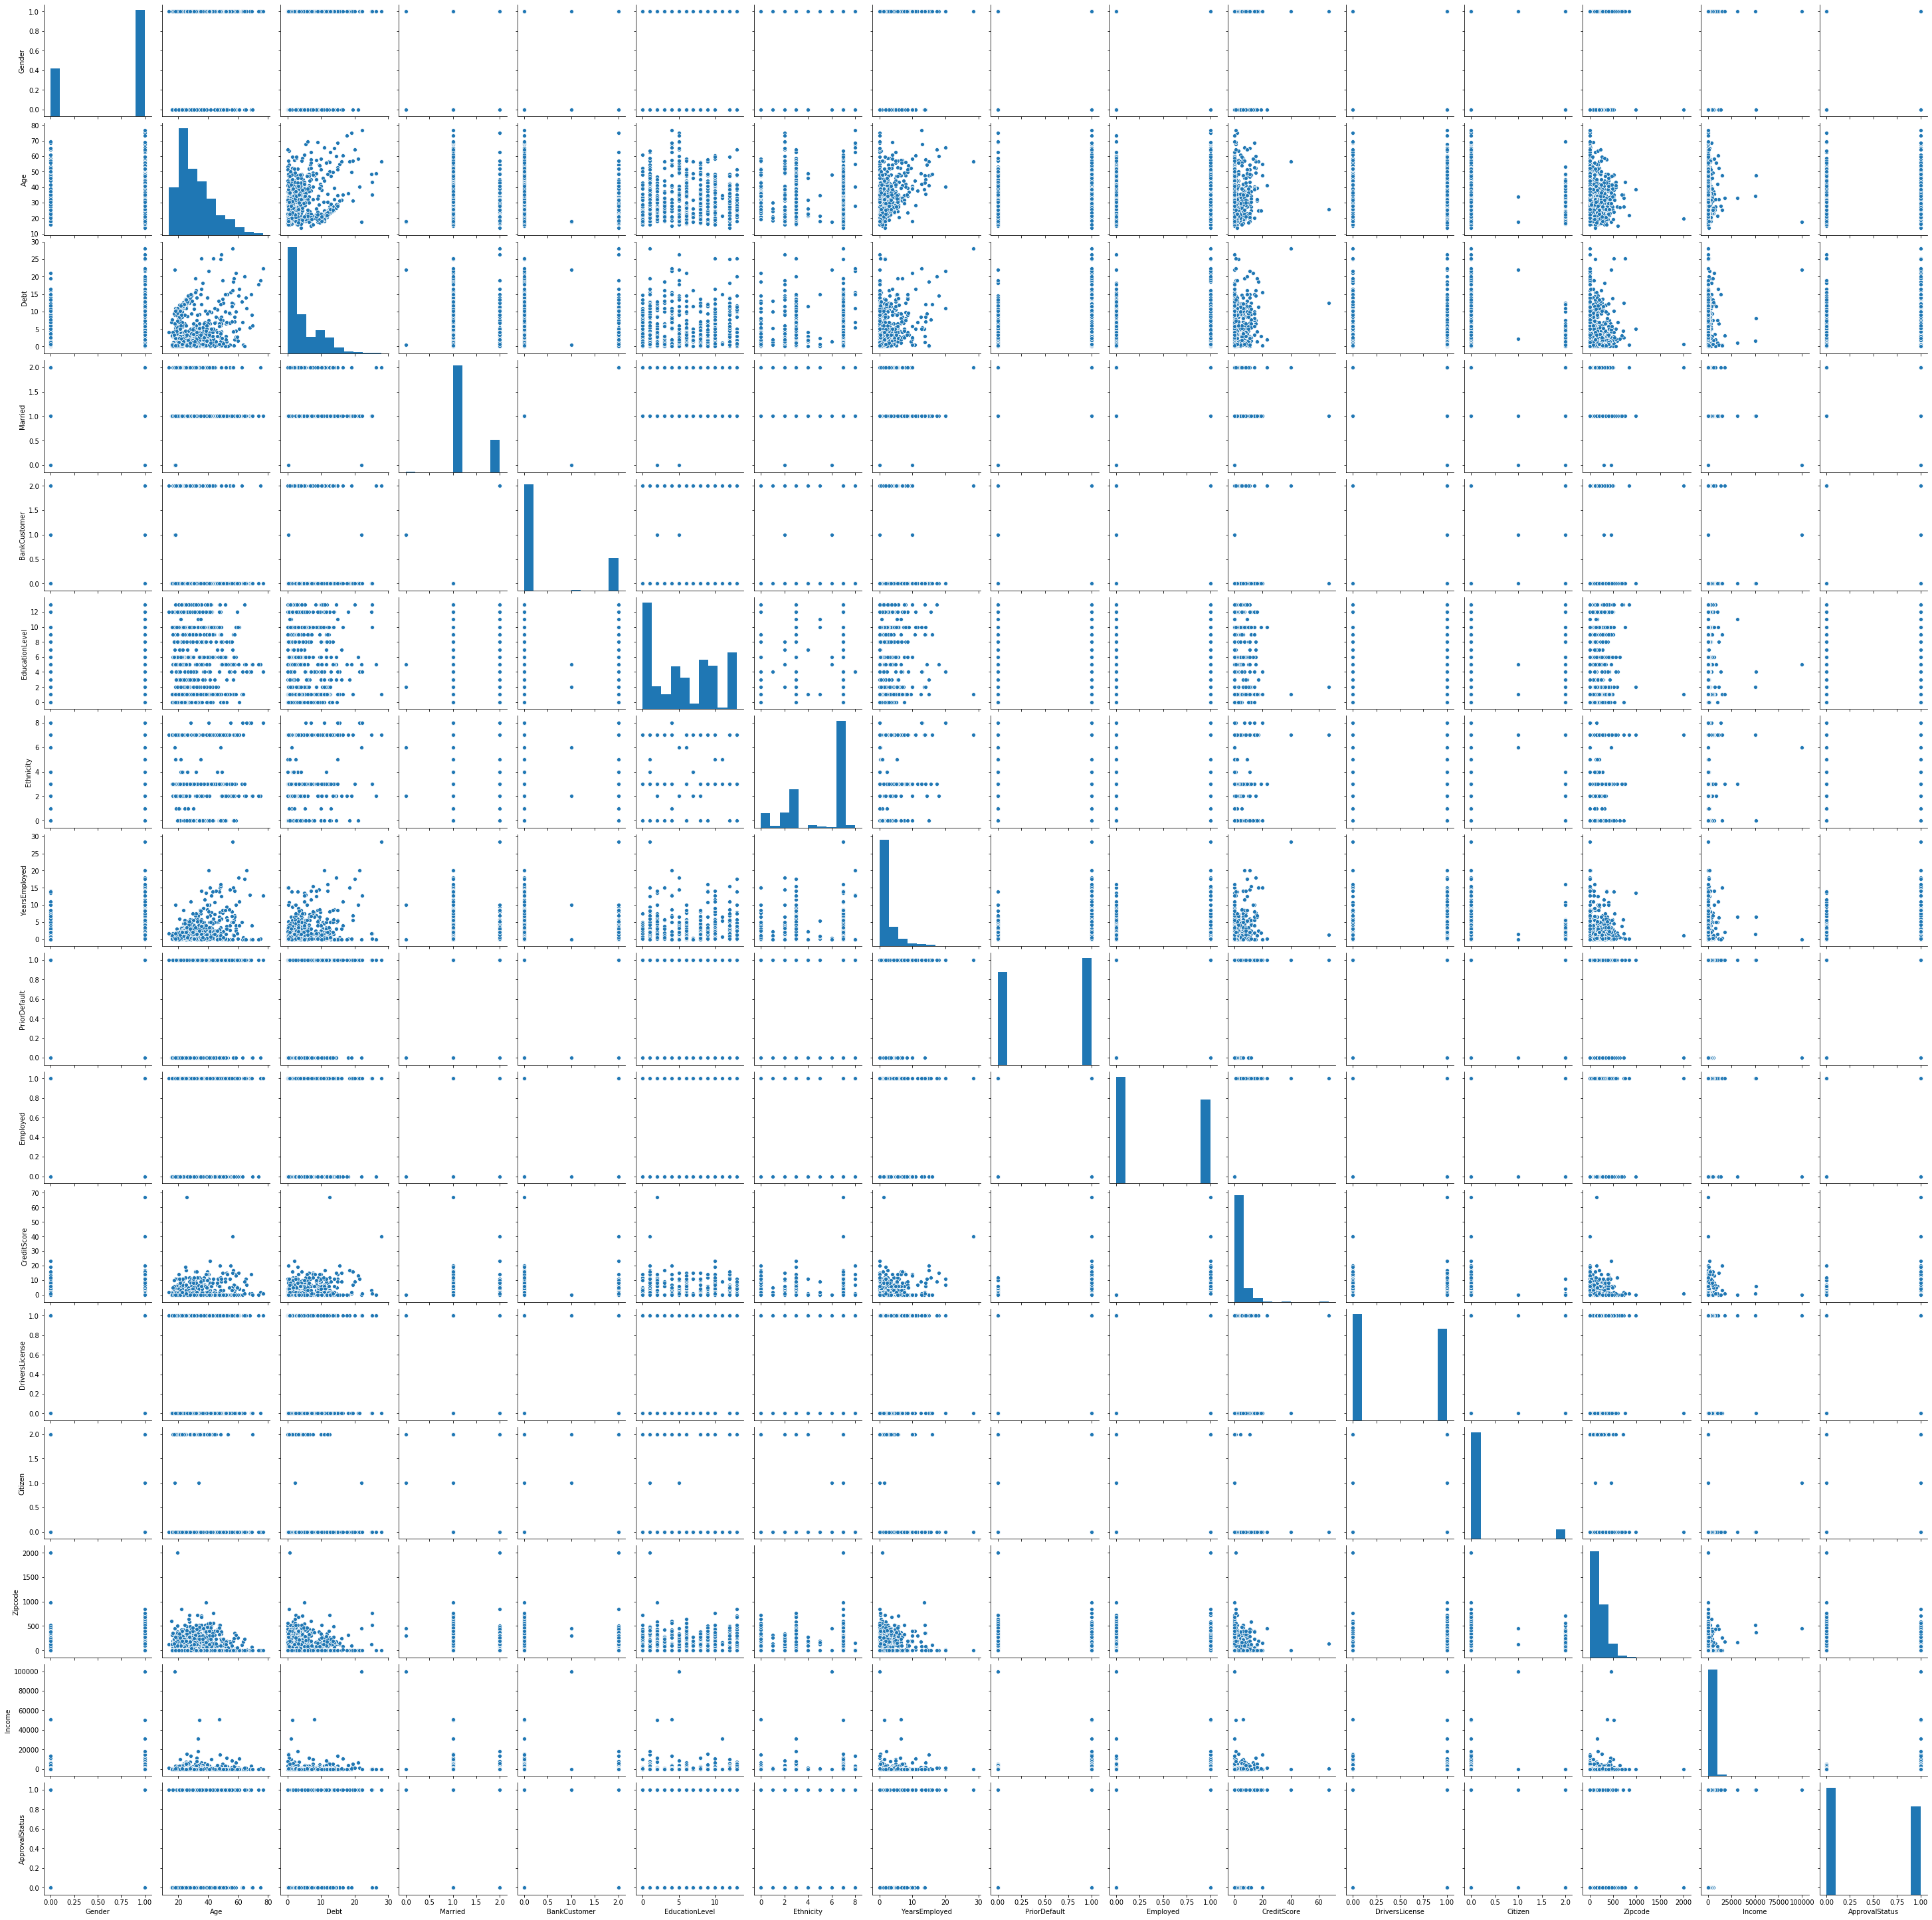

In [117]:
import seaborn as sns
sns.pairplot(cc_apps)


In [118]:
cc_apps.corr()


,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Zipcode,Income,ApprovalStatus
Gender,1.000000,0.042177,-0.034906,0.066742,0.063122,-0.011568,0.057212,0.084899,-0.023251,-0.065192,-0.016683,0.052315,0.081948,0.077617,0.013099,-0.019817
Age,0.042177,1.000000,0.217681,-0.091395,-0.105122,0.023282,-0.189454,0.417647,0.218637,0.103633,0.198153,0.058133,-0.021586,-0.084618,0.029078,0.180252
Debt,-0.034906,0.217681,1.000000,-0.102243,-0.089745,0.009221,-0.030666,0.300600,0.236751,0.166092,0.269834,-0.006083,-0.105181,-0.217076,0.119754,0.207086
Married,0.066742,-0.091395,-0.102243,1.000000,0.981080,-0.045024,-0.021015,-0.089650,-0.116015,-0.158118,-0.104061,-0.009850,-0.037934,0.011770,-0.118505,-0.179700
BankCustomer,0.063122,-0.105122,-0.089745,0.981080,1.000000,-0.051335,-0.026003,-0.081862,-0.129090,-0.169691,-0.110822,0.001747,-0.011931,0.024496,-0.018528,-0.169976
EducationLevel,-0.011568,0.023282,0.009221,-0.045024,-0.051335,1.000000,-0.000935,0.032704,0.105197,0.112155,-0.002706,0.069720,0.017234,0.084472,-0.006700,0.123314
Ethnicity,0.057212,-0.189454,-0.030666,-0.021015,-0.026003,-0.000935,1.000000,-0.094978,-0.034977,-0.001452,-0.037329,-0.004235,0.042494,-0.013047,-0.022527,-0.011023
YearsEmployed,0.084899,0.417647,0.300600,-0.089650,-0.081862,0.032704,-0.094978,1.000000,0.336148,0.228035,0.327325,0.139317,-0.001762,-0.064781,0.052159,0.332728
PriorDefault,-0.023251,0.218637,0.236751,-0.116015,-0.129090,0.105197,-0.034977,0.336148,1.000000,0.430586,0.378264,0.089864,-0.110474,-0.057225,0.084427,0.738829
Employed,-0.065192,0.103633,0.166092,-0.158118,-0.169691,0.112155,-0.001452,0.228035,0.430586,1.000000,0.569176,0.020223,-0.233452,-0.038994,0.068189,0.451866
